# The Effects of Policy Interventions on Covid19 - A case of London

When cases decline, which policy changes cause a change in trend?

CUSP London Data Dive

Group 2
Challenge C: Correlations and COVID19
7 April, 2022


## Case

COVID-19 cases in London during both Delta and Omicron declined before increasing. During the time, various policies were put into place. Which policy changes might have caused a change in trend?

This study looks at the change caused to rate of COVID19 cases due to specific policy interventions. Other policies considered: face coverings, school closure, event cancellations, and international travel restrictions.

Data source and structure:
- Daily case count data from UK Health and Security Agency (UKHSA)
- Oxford Covid-19 Government Response Tracker: recorded daily, coded by policy type, intervention intensity.

Scope and Limitations:
- With the decrease in severity of disease and increase in transmissibility, the study captures the time period after both Delta and Omicron saw a dip in cases.
- The study considers a 14 day period for the policy to take effect.
- The case count data further includes only those who tested themselves and were found to be positive, ergo excluding the number of people who did not test for COVID19.

## Result

Early 2022 (Omicron variant)

| Policy measures eased (early 2022, Omicron variant)           | Impact                             |
|:--------------------------------------------------------------|:-----------------------------------|
| face covering, event cancelling and work-from-home            | **significantly increased spread** |
| Opening schools and lifting international travel restrictions | no measurable direct impact        |

Policies were lifted individually in mid-2021 (Delta variant)

| Policy measures eased (mid-2021, Delta variant) | Impact                                                                 |
|:------------------------------------------------|:-----------------------------------------------------------------------|
| Event cancelling, work-from-home                | no measurable direct impact (face covering requirement still in place) |
| Face covering (reduced, not lifted)             | no measurable direct impact                                            |

This suggests: Keeping some form of masking requirement made a difference.

### Takeaways

1) Lifting mask requirements completely, together with other measures, with a more transmissible variant in winter, significantly increased spread.
2) Lifting the same restrictions in summer with a less transmissible variant and some mask requirements remaining, did not significantly increase spread.
3) School openings and allowing international travel had no direct measurable impact (early 2022).

## Change of facial covering policy

Three levels of face covering policy:

0: no mask
2: more masks
3: mask mask mask!

Methodology: *Interrupted time series regression*, results significant at $\alpha = 0.05$


In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns

covid_data = pd.read_csv('data/covid/covid_daily_roll.csv')
covid_data['date'] = pd.to_datetime(covid_data['date'])
policy_data = pd.read_csv("data/policies/eng-scot.csv", parse_dates=True)
policy_data['Date'] = pd.to_datetime(policy_data['Date'], format='%Y%m%d')

<AxesSubplot:xlabel='Date'>

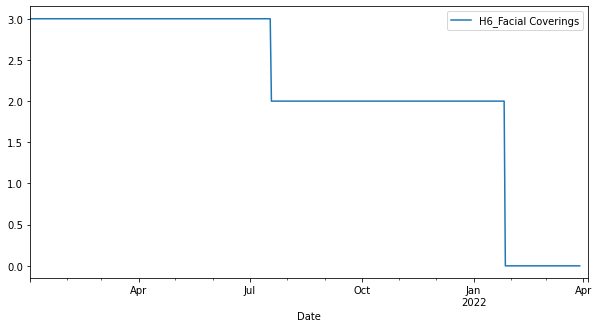

In [2]:
policy_data[(policy_data['Date'] > pd.to_datetime('2021-01-01')) & (policy_data['RegionName'] == 'England')].plot.line(y=['H6_Facial Coverings'], x='Date',figsize=(10, 5))

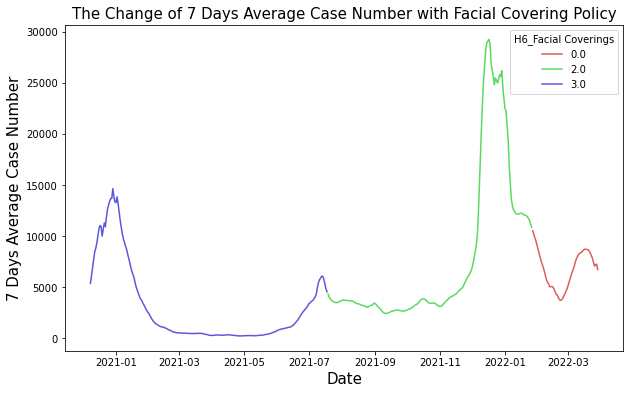

In [3]:
# Visualisation COVID cases in different phases of masking policy
df_merge = pd.merge(covid_data, policy_data[(policy_data['RegionName'] == 'England')],left_on='date', right_on='Date', how = 'left')

plt.figure(figsize=(10,6))
sns.lineplot(x='date',
             y='cases_roll_avg',
             hue = 'H6_Facial Coverings',
            data=df_merge,
            palette=sns.color_palette("hls", 3))
plt.ylabel('7 Days Average Case Number',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.title('The Change of 7 Days Average Case Number with Facial Covering Policy',fontsize=15)
plt.tick_params(labelsize=10)

In [4]:
def itr(intervention_name, policy_feature, level_post, startdate_str, offset):
    startdate = pd.to_datetime(startdate_str)
    y = covid_data.loc[covid_data['date'] > startdate, :]
    X = policy_data.loc[policy_data['RegionName'] == 'England', :]
    X.loc[X[policy_feature] == level_post, intervention_name] = 1
    X[intervention_name].fillna(0, inplace=True)
    X = X[X['Date'] > startdate]
    intdate = X[X[intervention_name] == 1]['Date'].sort_values().iloc[0]
    intdate_offset = intdate + datetime.timedelta(days=offset)
    X = X[X['Date'] < startdate + 2 * (intdate_offset-startdate)]
    y = y[y['date'] < startdate + 2 * (intdate_offset-startdate)]
    X['T'] = (X['Date'] - intdate).dt.days - offset # T is centered on the intervention date (it is 0 on the intervention date, negative before, positive after)
    data_reg2 = pd.merge(y, X, left_on='date', right_on='Date')
    reg2 = smf.glm(formula=f'slope_cases_roll_avg ~ T*{intervention_name}', data=data_reg2)
    res_reg2 = reg2.fit()
    print(f'Intervention date: {intdate}')
    print(f'Offset intervention date: {intdate_offset}')
    print(res_reg2.summary())

    fig, ax1 = plt.subplots(figsize=(10,5))
    ax2 = ax1.twinx()
    ax1.plot(y.set_index('date')['slope_cases_roll_avg'])
    ax2.plot(y.set_index('date')['cases_roll_avg'], color='red')
    plt.axvline(x=intdate, color='green')
    plt.axvline(x=intdate_offset, linestyle='--', color='green')
    plt.plot(figsize=(15, 5))

C:\Users\Wilkes\AppData\Local\Temp\ipykernel_6340\3741400637.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X[policy_feature] == level_post, intervention_name] = 1
C:\Users\Wilkes\AppData\Local\Temp\ipykernel_6340\3741400637.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[intervention_name].fillna(0, inplace=True)


Intervention date: 2022-01-27 00:00:00
Offset intervention date: 2022-02-10 00:00:00
                  Generalized Linear Model Regression Results                   
Dep. Variable:     slope_cases_roll_avg   No. Observations:                   61
Model:                              GLM   Df Residuals:                       57
Model Family:                  Gaussian   Df Model:                            3
Link Function:                 identity   Scale:                          14203.
Method:                            IRLS   Log-Likelihood:                -376.10
Date:                  Tue, 12 Apr 2022   Deviance:                   8.0955e+05
Time:                          22:44:05   Pearson chi2:                 8.10e+05
No. Iterations:                       3   Pseudo R-squ. (CS):             0.9681
Covariance Type:              nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

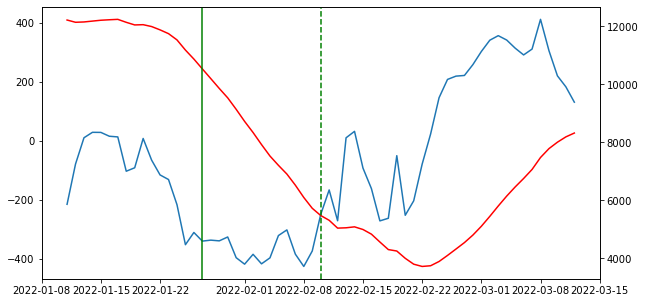

In [5]:
itr('nomask', 'H6_Facial Coverings', 0, '2022-01-10', 14)

C:\Users\Wilkes\AppData\Local\Temp\ipykernel_6340\3741400637.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X[policy_feature] == level_post, intervention_name] = 1
C:\Users\Wilkes\AppData\Local\Temp\ipykernel_6340\3741400637.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[intervention_name].fillna(0, inplace=True)


Intervention date: 2021-07-19 00:00:00
Offset intervention date: 2021-08-02 00:00:00
                  Generalized Linear Model Regression Results                   
Dep. Variable:     slope_cases_roll_avg   No. Observations:                   69
Model:                              GLM   Df Residuals:                       65
Model Family:                  Gaussian   Df Model:                            3
Link Function:                 identity   Scale:                          20922.
Method:                            IRLS   Log-Likelihood:                -439.07
Date:                  Tue, 12 Apr 2022   Deviance:                   1.3599e+06
Time:                          22:44:05   Pearson chi2:                 1.36e+06
No. Iterations:                       3   Pseudo R-squ. (CS):             0.3326
Covariance Type:              nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------

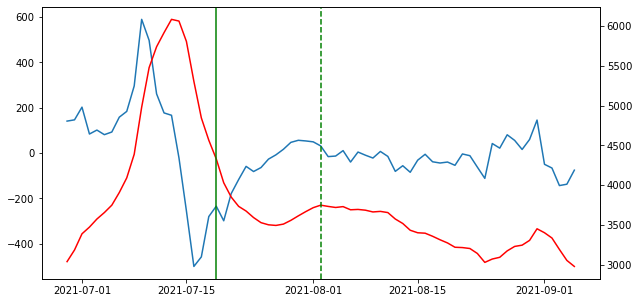

In [6]:
itr('maskingdelta', 'H6_Facial Coverings', 2, '2021-06-28', 14)

## Policy and Wave

Delta 2021 summer:
- Intensity of many policies decreased ✅
- Case number rises again ❌
- Lift of policies significantly increased spread ❌

Omicron 2022 spring:
- Intensity of many policies decreased ✅
- Case number rises again ✅
- Lift of policies significantly increased spread ✅

<AxesSubplot:title={'center':'COVID-19 mitigation policy stringency indices - England'}, xlabel='Date'>

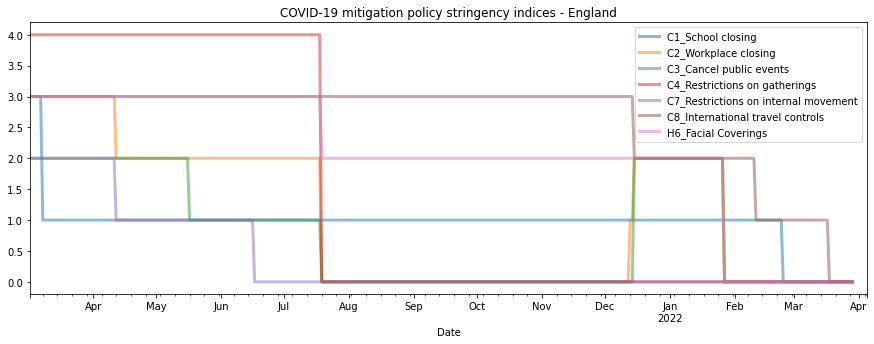

In [7]:
policy_data[(policy_data['Date'] > pd.to_datetime('2021-03-01')) & (policy_data['RegionName'] == 'England')].plot.line(y=[
    'C1_School closing',
    'C2_Workplace closing',
    'C3_Cancel public events',
    'C4_Restrictions on gatherings',
    #'C5_Close public transport',
    #'C6_Stay at home requirements',
    'C7_Restrictions on internal movement',
    'C8_International travel controls',
    #'H3_Contact tracing',
    'H6_Facial Coverings',
    #'H8_Protection of elderly people',
    #'M1_Wildcard',
    #'H7_Vaccination policy'
],x='Date',figsize=(15, 5), alpha=.5, lw=3, title='COVID-19 mitigation policy stringency indices - England')

<AxesSubplot:title={'center':'London infections - 7 day average'}, xlabel='date'>

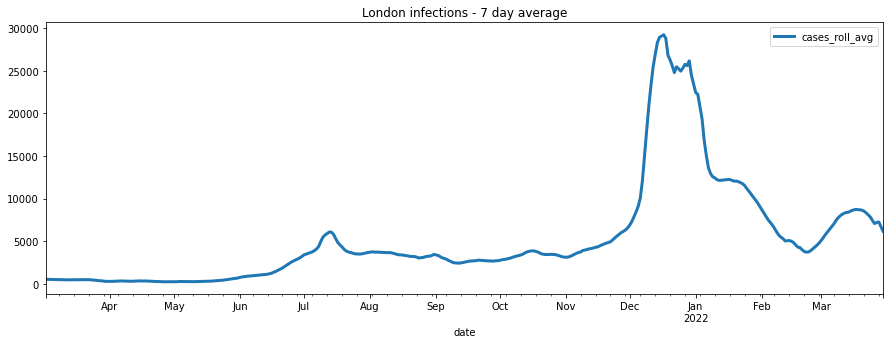

In [8]:
covid_data[(covid_data['date'] > pd.to_datetime('2021-03-01'))].plot(
    x='date',
    y='cases_roll_avg',
    figsize=(15, 5),
    lw=3,
    title='London infections - 7 day average'
)